In [2]:
import time
import json
import pandas as pd
import numpy as np
import ast
import random
import warnings
warnings.filterwarnings('ignore')

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# nlp libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ensure you have the required NLTK data
# nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('stopwords')

In [3]:
df = pd.read_csv('processed_data.csv')
df[['review_text', 'processed_review_text_NLTK', 'processed_review_text_SPACY']].head(2)

,review_text,processed_review_text_NLTK,processed_review_text_SPACY
0,This is a special book. It started slow for ab...,special book started slow first third middle t...,special book start slow middle start interesti...
1,Recommended by Don Katz. Avail for free in Dec...,recommended katz avail free december http,recommend don katz avail free december http://...


### Comparing NLTK and Spacy results

In [4]:
print('This is the original review (1st instance in our data):\n\n', df[['review_text', 'processed_review_text_NLTK', 'processed_review_text_SPACY']]['review_text'].iloc[0])

This is the original review (1st instance in our data):

 This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read. For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc. It is a book about science, and aliens. The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell. Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though. But what would happen if our SETI stations received a message - if we found someone was out there - and the person monit

In [5]:
print('Length of the original review text:', len(df[['review_text', 'processed_review_text_NLTK', 'processed_review_text_SPACY']]['review_text'].iloc[0]))
print('Length of Spacy processed text:', len(df[['review_text', 'processed_review_text_NLTK', 'processed_review_text_SPACY']]['processed_review_text_SPACY'].iloc[0]))
print('Length of NLTK processed text:', len(df[['review_text', 'processed_review_text_NLTK', 'processed_review_text_SPACY']]['processed_review_text_NLTK'].iloc[0]))


Length of the original review text: 2074
Length of Spacy processed text: 1071
Length of NLTK processed text: 1320


Let's do some considerations for choosing the more suitable version for sentiment analysis and topic modeling.

###  **NLTK processed text:**
* **Lemmatization**: NLTK sometimes keeps words in their original form (e.g., "started", "translated"). The NLTK processed text retains more detail and context, which can be beneficial for sentiment analysis as it keeps more nuanced information. 
* **Common Words**: Some common words are retained, which might help in sentiment analysis, as words like "not", "but", "though" can be important for determining sentiment.
###  **Spacy processed text:**
* **Lemmatization**: spaCy reduces more words to their base forms (e.g., "start" "started", "translate" instead of "translated") . This can lead to a difference in word count. Also, phrases are more condensed. For instance, "started slow first third middle third started get interesting" is reduced to "start slow middle start interesting".
* **Stop Words:** Spacy considers some common such as stop words and removes them (for example "though"), meanwhile NLTK leaves those words. <br>

### So what approach is more suitable for sentiment analysis and topic modeling?<br>

## Sentiment Analysis:
**NLTK**: For sentiment analysis, retaining detail and context is often more beneficial due to the nuanced nature of sentiments expressed in reviews. Therefore, NLTK might be more suitable for this task as it retains more context and common words that are important for determining sentiment.
## Topic Modeling:
**Spacy**: spaCy's approach of normalizing words can be helpful for topic modeling where focusing on word meaning is crucial. It helps in reducing noise and grouping similar words together, making the topics more coherent.


# 5. Sentiment Analysis with NLTK


In [6]:
print('Percentage of NaN values after running NLTK:', (df[df['processed_review_text_NLTK'].isnull()].shape[0]/df.shape[0])*100)

Percentage of NaN values after running NLTK: 0.03548536210671297


NaN values occurr when punctuation removal or stop word removal results empty strings for some of the values in  data. By looking at the original data, I can assume that probably NLTK considered that some of the reviews consist only of stop words or had a lot of punctuation that's why it returned an empty string after preprocessing and we got NaN values.

I'm considering dropping it as it is a very low number of data, but before dropping it let's check  wheter we have valuable information. 
As we can see below, most of the reviews are similar and don't contain valuable information, so I'll drop them.

In [7]:
# df[df['processed_review_text_NLTK'].isnull()]['review_text'].unique()

In [8]:
df = df.dropna(subset=['processed_review_text_NLTK'])
df = df.reset_index(drop=True)

Now that our data is ready, I'm going to conduct the following steps:

1. Create Bigrams
2. Calculate Sentiment Scores
3. Visualize Sentiment Scores Distribution
4. Classify Reviews into Positive and Negative
5. Generate Word Clouds for Positive and Negative Reviews
6. Topic Modeling with SpaCy

### 1. Create Bigrams

In [9]:
df['tokens'] = df['processed_review_text_NLTK'].apply(lambda x: x.split())

def get_bigrams(tokens):
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigrams = bigram_finder.ngram_fd.items()
    return list(bigrams)
start_time = time.time()
df['bigrams'] = df['tokens'].apply(get_bigrams)
end_time = time.time()
duration = (end_time - start_time)/ 60
print(f"get_bigrams function execution time: {duration:.2f} minutes")

get_bigrams function execution time: 17.80 minutes


In [10]:
# flatten the list of bigrams and count their frequencies
bigram_list = [bigram for sublist in df['bigrams'] for bigram in sublist]
bigram_freq = Counter(bigram_list)

# get the 20 most common bigrams
common_bigrams = bigram_freq.most_common(20)

bigram_df = pd.DataFrame(common_bigrams, columns=['bigram', 'frequency'])
bigram_df['bigram'] = bigram_df['bigram'].apply(lambda x: ' '.join(x[0]))

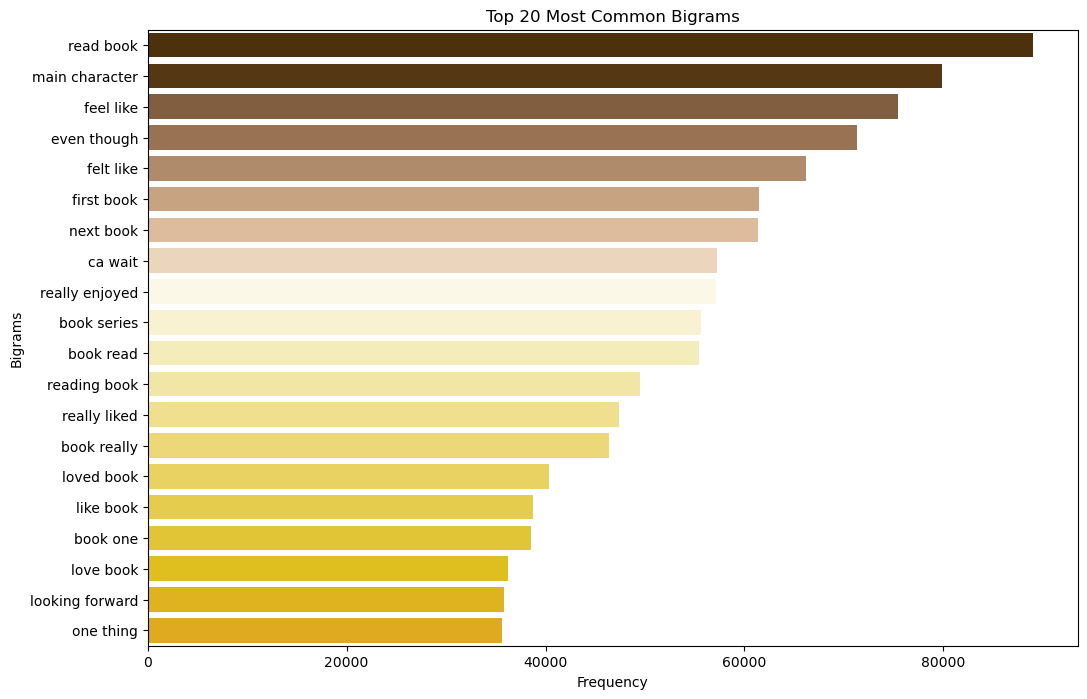

In [32]:
colors = ['#583101', '#603808', '#8B5E34', '#A47148', '#BC8A5F', '#D4A276', '#E7BC91', '#F3D5B5','#fffae5','#fff6cc','#fff2b2','#ffee99','#ffe97f','#ffe566','#ffe14c','#ffdd32','#ffd819','#ffd400', '#ffc300', '#ffb700']

plt.figure(figsize=(12, 8))
sns.barplot(x='frequency', y='bigram', data=bigram_df, palette=colors)
plt.title('Top 20 Most Common Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

### 2. Calculate Sentiment Scores

In [12]:
sid = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

def get_sentiment_scores(text):
    if pd.isna(text):
        return {'compound': 0, 'neg': 0, 'neu': 0, 'pos': 0}
    return sid.polarity_scores(text)
start_time = time.time()
df['sentiment_scores'] = df['processed_review_text_NLTK'].apply(get_sentiment_scores)
df['compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])
df['neg'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['neu'] = df['sentiment_scores'].apply(lambda x: x['neu'])
df['pos'] = df['sentiment_scores'].apply(lambda x: x['pos'])
end_time = time.time()
duration = (end_time - start_time)/ 60
print(f"get_sentiment_scores function execution time: {duration:.2f} minutes")

get_sentiment_scores function execution time: 23.55 minutes


In [13]:
df[['compound', 'neg', 'neu', 'pos']].describe().round(3)

,compound,neg,neu,pos
count,1377544.000,1377544.000,1377544.000,1377544.000
mean,0.626,0.111,0.579,0.310
std,0.533,0.102,0.149,0.154
min,-1.000,0.000,0.000,0.000
25%,0.494,0.032,0.503,0.221
50%,0.896,0.100,0.580,0.297
75%,0.979,0.161,0.653,0.387
max,1.000,1.000,1.000,1.000


* Most reviews are highly positive, as indicated by the compound sentiment score distribution.
* Negative sentiment is low in most reviews, with very few reviews having high negative sentiment scores.
* Neutral sentiment is present in a substantial portion of the text, peaking around 0.6.
* Positive sentiment is moderate to high in most reviews, with many reviews showing a significant amount of positive sentiment.

### 3. Visualize Sentiment Scores Distribution

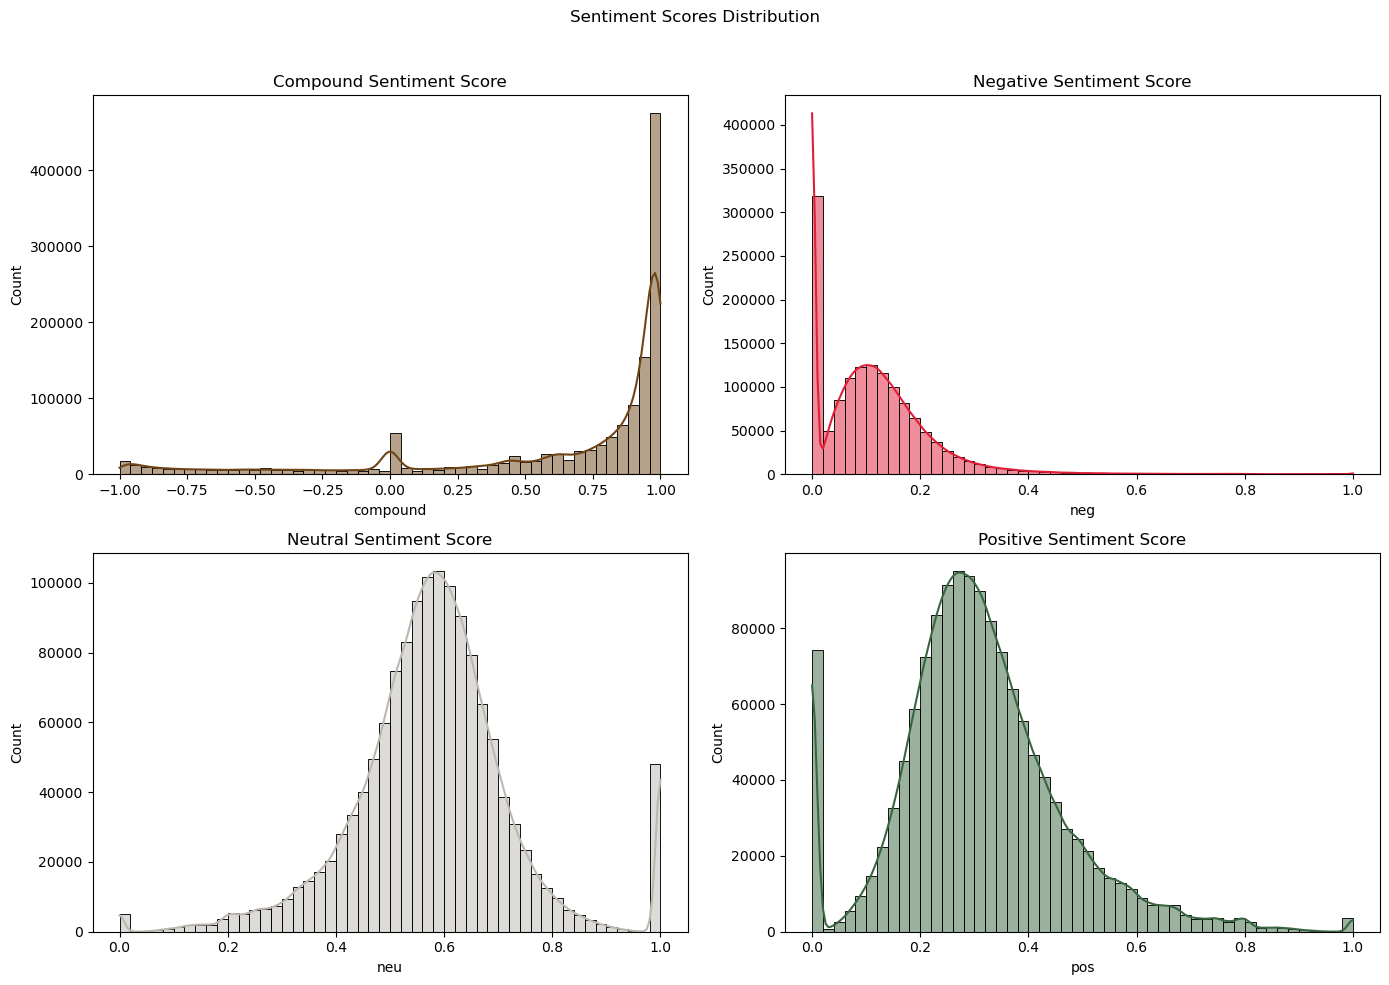

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Sentiment Scores Distribution')

sns.histplot(df['compound'], bins=50, kde=True, ax=axes[0, 0], color='#6F4518')
axes[0, 0].set_title('Compound Sentiment Score')

sns.histplot(df['neg'], bins=50, kde=True, ax=axes[0, 1], color='#e01e37')
axes[0, 1].set_title('Negative Sentiment Score')

sns.histplot(df['neu'], bins=50, kde=True, ax=axes[1, 0], color='#bcb8b1')
axes[1, 0].set_title('Neutral Sentiment Score')

sns.histplot(df['pos'], bins=50, kde=True, ax=axes[1, 1], color='#386641')
axes[1, 1].set_title('Positive Sentiment Score')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

* The average sentiment score (compound) is positive, with a mean of 0.626.
* There is a mix of negative, neutral, and positive sentiments in the reviews, but on average, reviews are more neutral and positive than negative.
* The distribution of sentiment scores shows that most reviews have a high compound score, with a median of 0.896.
* Negative sentiment is less common, with a mean of 11.1%, while neutral sentiment is the most common, with a mean of 57.9%.
* Positive sentiment makes up about 31.0% of the reviews on average.

### 4. Classify Reviews into Positive and Negative

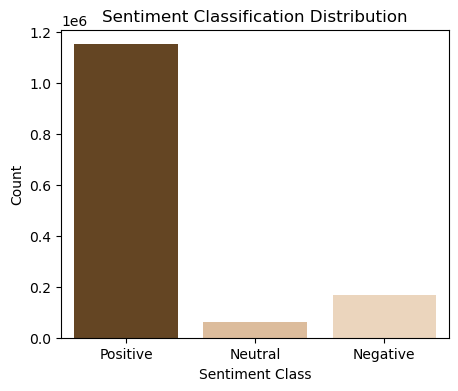

In [15]:
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_class'] = df['compound'].apply(classify_sentiment)

plt.figure(figsize=(5, 4))
colors = ['#6F4518', '#E7BC91', '#F3D5B5']

sns.countplot(x='sentiment_class', data=df, palette=colors)
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.title('Sentiment Classification Distribution')
plt.show()

In [16]:
sentiment_counts = df['sentiment_class'].value_counts()

positive_percentage = (sentiment_counts['Positive'] / len(df)) * 100
negative_percentage = (sentiment_counts['Negative'] / len(df)) * 100
neutral_percentage = (sentiment_counts['Neutral'] / len(df)) * 100

print(f"Percentage of Positive Reviews: {positive_percentage:.2f}%")
print(f"Percentage of Negative Reviews: {negative_percentage:.2f}%")
print(f"Percentage of Neutral Reviews: {neutral_percentage:.2f}%")

Percentage of Positive Reviews: 83.57%
Percentage of Negative Reviews: 12.10%
Percentage of Neutral Reviews: 4.34%


### 5. Generate Word Clouds for Positive and Negative Reviews

In [17]:
all_positive_words_list = df[df['sentiment_class']=='Positive']['processed_review_text_SPACY'].str.split().tolist()
all_negative_words_list = df[df['sentiment_class']=='Negative']['processed_review_text_SPACY'].str.split().tolist()
all_neutral_words_list = df[df['sentiment_class']=='Neutral']['processed_review_text_SPACY'].str.split().tolist()

def extract_words(nested_list):
    words = []
    for item in nested_list:
        if isinstance(item, list):
            words.extend(extract_words(item))
        else:
            words.append(item)  
    return words

flat_list_pos = extract_words(all_positive_words_list)
flat_list_neg = extract_words(all_negative_words_list)
flat_list_neu = extract_words(all_neutral_words_list)

print(f"Number of positive unique words: {len(flat_list_pos)}")
print(f"Number of negative unique words: {len(flat_list_neg)}")
print(f"Number of neutral unique words: {len(flat_list_neu)}")

Number of positive unique words: 94735901
Number of negative unique words: 12129907
Number of neutral unique words: 713504


In [18]:
# Create a Counter object
word_counts_pos = Counter(flat_list_pos)
word_counts_neg = Counter(flat_list_neg)
word_counts_neu = Counter(flat_list_neu)

positive_words_df = pd.DataFrame(pd.Series(word_counts_pos), columns=['Count']).sort_values(by='Count', ascending=False)
positive_words_df.index = positive_words_df.index.set_names(['Word'])
positive_words_df.reset_index(inplace=True)

negative_words_df = pd.DataFrame(pd.Series(word_counts_neg), columns=['Count']).sort_values(by='Count', ascending=False)
negative_words_df.index = negative_words_df.index.set_names(['Word'])
negative_words_df.reset_index(inplace=True)

neutral_words_df = pd.DataFrame(pd.Series(word_counts_neu), columns=['Count']).sort_values(by='Count', ascending=False)
neutral_words_df.index = neutral_words_df.index.set_names(['Word'])
neutral_words_df.reset_index(inplace=True)

positive_words_df.columns = ['Word', 'Count_Positive']
negative_words_df.columns = ['Word', 'Count_Negative']
neutral_words_df.columns = ['Word', 'Count_Neutral']

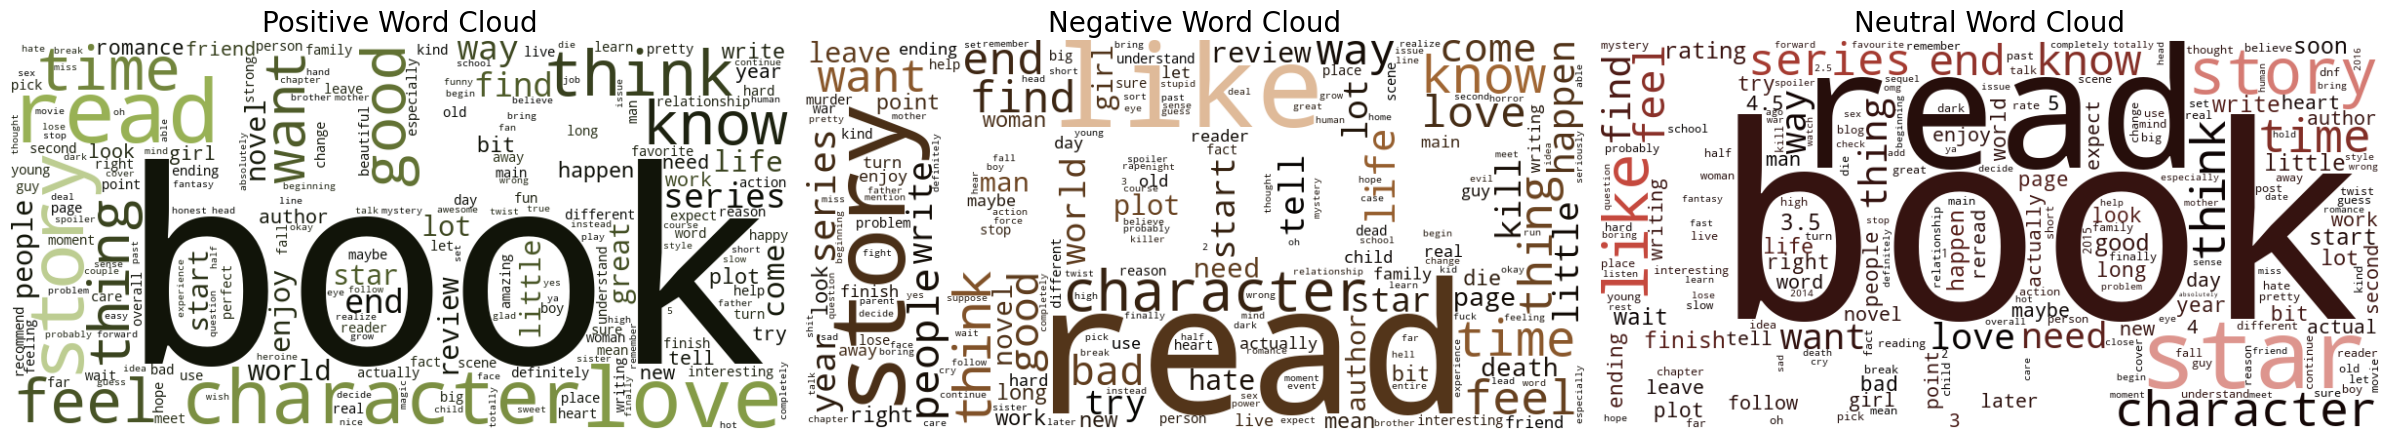

In [22]:
positive_frequencies = dict(zip(positive_words_df['Word'], positive_words_df['Count_Positive']))
negative_frequencies = dict(zip(negative_words_df['Word'], negative_words_df['Count_Negative']))
neutral_frequencies = dict(zip(neutral_words_df['Word'], neutral_words_df['Count_Neutral']))

# custom color functions
def positive_color_func(word, font_size, position, random_state, **kwargs):
    return "hsl(76, 37%, {:.2f}%)".format(font_size * random_state.random())

def negative_color_func(word, font_size, position, random_state, **kwargs):
    return "hsl(28, 52%, {:.2f}%)".format(font_size * random_state.random())

def neutral_color_func(word, font_size, position, random_state, **kwargs):
    return "hsl(5, 54%, {:.2f}%)".format(font_size * random_state.random())

# create word clouds with custom color functions
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=positive_color_func).generate_from_frequencies(positive_frequencies)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=negative_color_func).generate_from_frequencies(negative_frequencies)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=neutral_color_func).generate_from_frequencies(neutral_frequencies)

fig, axes = plt.subplots(1, 3, figsize=(24, 10))

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Positive Word Cloud', fontsize=20)
axes[0].axis('off')

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title('Negative Word Cloud', fontsize=20)
axes[1].axis('off')

axes[2].imshow(neutral_wordcloud, interpolation='bilinear')
axes[2].set_title('Neutral Word Cloud', fontsize=20)
axes[2].axis('off')

plt.tight_layout()
plt.show()


* Common words such as "book," "character," "read," "story," "like," and "love" are frequently mentioned across all sentiment categories, reflecting key themes and elements typically discussed in book reviews.
* The word "love," for instance, appears predominantly in positive reviews (1,326,970 times) compared to negative (58,696 times) and neutral (2,898 times) reviews.


### 6. Topic Modeling with SpaCy

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

text_column = 'processed_review_text_SPACY'
tp_df = df.dropna(subset='processed_review_text_SPACY')
documents = tp_df[text_column].tolist()

In [24]:
vectorizer = CountVectorizer(max_features=1000, 
                             max_df=0.95,       # ignore terms that appear in more than 95% of the documents
                             min_df=2,          
                             stop_words='english')

# fit and transform the text data
X = vectorizer.fit_transform(documents)

feature_names = vectorizer.get_feature_names_out()

In [25]:
num_topics = 15
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# function to display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

# number of top words to display for each topic
no_top_words = 10
start_time = time.time()
print("Top words per topic:")
display_topics(lda, feature_names, no_top_words)
end_time = time.time()
duration = (end_time - start_time)/ 60
print(f"display_topics function execution time: {duration:.2f} minutes")

Top words per topic:
Topic 1:
book like read think feel know thing character time people

Topic 2:
love romance book read heroine story character hero sweet fun

Topic 3:
novel world book character fantasy mystery story magic reader king

Topic 4:
story series end great character read ending love enjoy little

Topic 5:
harry tale kate fairy sam like anna read love prince

Topic 6:
love life want man know like woman way relationship time

Topic 7:
like love book think good thing guy read lot feel

Topic 8:
girl school book friend good like boy character high kid

Topic 9:
book read story like write think feel time star writing

Topic 10:
story book people life character time world human way woman

Topic 11:
book series read vampire good love wait think like character

Topic 12:
love book read amazing story character want know heart review

Topic 13:
review year book read old family come life story new

Topic 14:
book character like read plot feel enjoy story interesting good

Topic 15:


General Observations:

"Book" is the most frequent word across many topics, reflecting the focus on reading materials.
Words like "love," "like," "read," "think," and "character" appear frequently, suggesting a mix of general reading experience, sentiment, and character analysis.

* Romance (Topic 2): Words like "love," "romance," "heroine," and "sweet" indicate a clear focus on romantic themes.
* Fantasy (Topic 3): Words like "novel," "world," "fantasy," "magic," and "king" suggest a topic related to fantasy novels.
* Series (Topic 4): Words like "story," "series," "end," and "enjoy" point towards a theme of books that are part of a series.
* Young Adult Fiction (Topic 5): Words like "harry," "tale," "kate," "fairy," and "prince" suggest a topic related to Young Adult fiction, possibly featuring specific characters or series.
* Coming-of-Age (Topic 8): Words like "girl," "school," "friend," "high," and "kid" hint at a theme of coming-of-age stories set in school environments.
* Life & Relationships (Topic 6): Words like "love," "life," "want," "man," "woman," and "relationship" suggest a broader theme of life and relationships.
* Review & Recommendation (Topic 13): Words like "review," "year," "old," "family," and "new" might indicate a topic related to reviews and recommendations of books.

Other Topics:

Several other topics capture various aspects of reading experience and book content, such as general sentiment (Topic 7), writing process (Topic 9), character analysis (Topic 14), and broader themes (Topics 1, 10, 15).

In [26]:
# get topic assignments for each document
topic_assignments = lda.transform(X)

# assign the most probable topic to each document
tp_df['topic'] = topic_assignments.argmax(axis=1)

print(tp_df[['processed_review_text_SPACY', 'topic']].head())

                         processed_review_text_SPACY  topic
0  special book start slow middle start interesti...      9
1  recommend don katz avail free december http://...     12
2  fun fast pace science fiction thriller read 2 ...      9
3  recommend reading understand middle america po...     12
4  enjoy book lot recommend drag little end knock...      9


Based on set of words appearing in various topics I'll assign name to them: 

In [27]:
tp_df['Topic Name'] = np.where(tp_df['topic']==2, 'Romance',
                              np.where(tp_df['topic']==3, 'Fantasy',
                                      np.where(tp_df['topic']==4, 'Series',
                                              np.where(tp_df['topic']==5, 'Young Finction',
                                                      np.where(tp_df['topic']==6, 'Life & Relationships',
                                                              np.where(tp_df['topic']==8, 'Coming-of-Age',
                                                                      np.where(tp_df['topic']==9, 'Writing Process',
                                                                              np.where(tp_df['topic']==13, 'Review & Recommendation',
                                                                                      np.where(tp_df['topic']==14, 'Character Analysis', 'General reading experience')))))))))


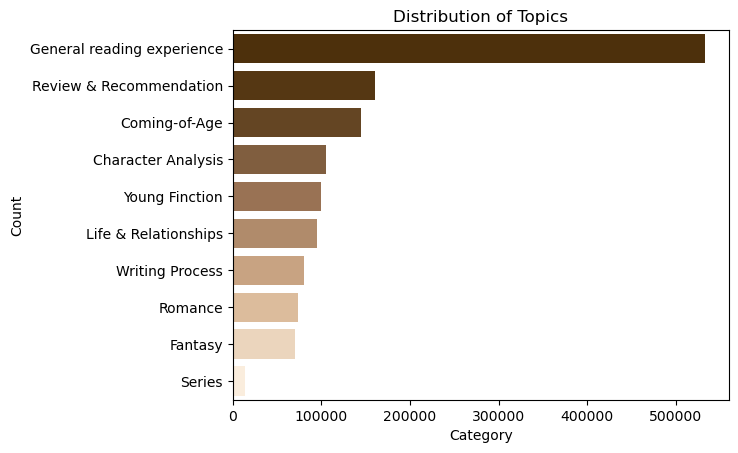

In [33]:
colors = ['#583101', '#603808', '#6F4518', '#8B5E34', '#A47148', '#BC8A5F', '#D4A276', '#E7BC91', '#F3D5B5', '#FFEDD8']
sns.barplot(x=tp_df['Topic Name'].value_counts().values,
            y=tp_df['Topic Name'].value_counts().index,
           palette=colors) 
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Topics')
plt.xticks()  
plt.show()

The dominant topic is 'General reading experience' and the less discussed topic is 'Series'.

Our analysis of Goodreads book reviews using NLTK and spaCy highlights the differences between the libraries. NLTK's context retention is beneficial for sentiment analysis, while spaCy's normalization suits topic modeling. Possible future work may include deeper analyses and model performance comparisons.